In [1]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

In [2]:
with open('order_dict.json') as f:
    data = json.load(f)
with open('warehouse_capacity.json') as f2:
    warehouse_capacity = json.load(f2)

In [3]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [4]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [5]:
# def r2_loss(outputs, targets):
#     target_mean = torch.mean(targets)
#     ss_tot = torch.sum((targets - target_mean) ** 2)
#     ss_res = torch.sum((targets - outputs) ** 2)
#     r2 = 1 - ss_res / ss_tot
#     return r2

# def r2_loss_2(outputs, targets):
#     ss_tot = 0.0
#     ss_res = 0.0
#     target_mean = torch.mean(targets)
#     for i in range(0,len(outputs)):
#         ss_tot += (targets[i] - target_mean) ** 2
#         ss_res += (targets[i] - outputs[i]) ** 2
#     r2 = 1 - ss_res / ss_tot
#     return r2

def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = 1000.0 / 31
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost

def SPO_MSE_Loss(d_pred, d_actual):
    spo_loss = SPOLoss(d_pred, d_actual)
    mse_loss = 0.0
    for i in range(0, len(d_pred)):
      mse_loss += (d_pred[i] - d_actual[i]) ** 2
    mse_loss = mse_loss / len(d_pred)
    # mse_loss = sum((d_pred - d_actual) ** 2) / len(d_pred)    # don't use this, because d_pred can is 1*N dimention but d_actual can be N*1 dimension
    return 0.5 * spo_loss + 0.5 * mse_loss

# print(torch.Tensor.float(1.0))
# outputs = torch.randn(5)
# targets = torch.randn(5)
outputs = torch.tensor([1,2,3,4,6])
targets = torch.tensor([[1],[2],[3],[4],[5]])
# print(outputs.size())
# print(r2_loss(outputs,targets))
# print(r2_loss_2(outputs,targets))
print(SPOLoss(outputs,targets))
print(SPO_MSE_Loss(outputs,targets))
# print(torch.randn(5))
# print(SPOLoss(1, 2))

tensor([2.9200])
tensor([1.5600])


In [6]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    elif loss_type == 'SPO_MSE': # change loss function and switch to adam optimizer
        
        criterion = SPO_MSE_Loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(epochs),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))
        # print('Train SPO MSE weighted Loss =', SPO_MSE_Loss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    SPO_MSE = SPO_MSE_Loss(y_pred, y_true)
    SPO_MSE_mean = SPO_MSE / len(y_pred)
    #print("Train MSE =", MSE)
    #print('Train R^2 =', R2) 
    #print('Train SPO Loss =', SPO)
    # return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO Loss Ave': SPO_mean})
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO_Loss': SPO, 'SPO_Loss_Per_Ord': SPO_mean, 'SPO_MSE_Weighted_Loss': SPO_MSE, 'SPO_MSE_Weighted_Loss_Per_Ord': SPO_MSE_mean})

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [8]:
import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    
    # return the best penalty coefficient that minimize average validation error
    start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 501
        grid = np.linspace(0,0.5,11) if regularize == 'l2' else np.linspace(0,1,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 301
        grid = np.linspace(3,4,6) if regularize == 'l2' else np.linspace(10,20,5)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(list(aveloss.keys()), list(aveloss.values()))
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    print('The best penalty coefficient is '+ str(best))
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    return best

In [9]:
x_train, y_train, x_test, y_test = preprocessing(order_dict[1])

In [10]:
# cross_validate(x_train, y_train, 'MSE', 'l2')

In [11]:
# cross_validate(x_train, y_train, 'MSE', 'l1')

In [12]:
# cross_validate(x_train, y_train, 'SPO', 'l2')

In [13]:
# cross_validate(x_train, y_train, 'SPO', 'l1')

## MSE loss models

### MSE loss model training

model trained using MSE loss
y-intercept  14.353525161743164
Coefficients  [[-0.4840188  -0.03900876 -0.14855808  0.46073955  1.327927    0.20060228
  -0.98258567 -0.37783122  0.8468291   0.24343911  2.0036995   5.170976
  -0.55786055  0.21740349  6.0072284   0.14041007  1.2343911  -1.3527972
  -1.8189921   5.4343038   3.7525501   2.4210637   6.247386   -6.4319534
  -0.5513478   2.732894    0.03547433  0.71977407  0.36031434 -0.04083706
   0.4120284   2.2189748   0.69931453 -0.42943773 -0.3655209 ]]
Train MSE = 58.0007113792909
Train R^2 = 0.7639109176110757
Train SPO Loss = [2050.9364306]


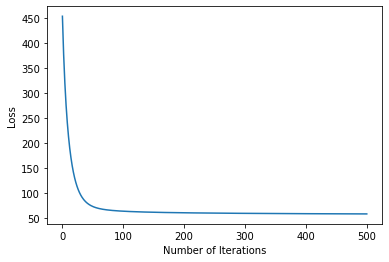

In [14]:
# ols model training

learningRate = 0.02
epochs = 501

model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None')

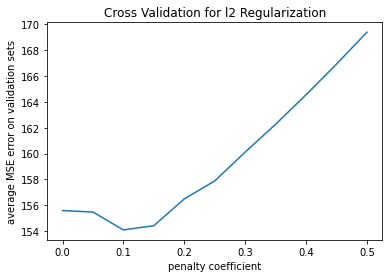

The best penalty coefficient is 0.1
Time:  7.55731832299999
model trained using MSE loss
y-intercept  13.670023918151855
Coefficients  [[-4.1255641e-01  4.7001587e-03 -1.5989697e-01  3.0329889e-01
   8.0954075e-01  2.7556261e-01 -5.4480058e-01 -6.0297108e-01
   9.6880686e-01  9.9064477e-02  1.6657979e+00  3.7513702e+00
  -4.9914101e-01  6.8695807e-01  5.6639667e+00 -1.9269466e-01
   1.3187326e+00 -1.2047366e+00 -1.6709930e+00  5.1996107e+00
   2.8086519e+00  1.7939242e+00  5.9636612e+00 -5.1600628e+00
  -7.7872658e-01  2.3669221e+00 -4.2534597e-02  4.6685272e-01
   1.9483139e-01 -4.1927963e-02  3.4326333e-01  2.1319270e+00
   6.2268656e-01 -4.3269673e-01 -3.7241122e-01]]
Train MSE = 60.26078761963276
Train R^2 = 0.7547113868980466
Train SPO Loss = [1926.06217673]


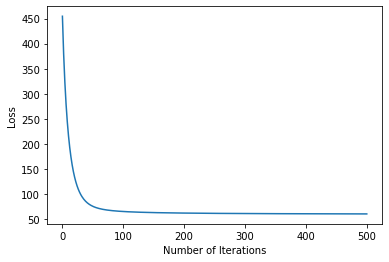

In [15]:
# ridge regression (l2 regrularization)

learningRate = 0.02
epochs = 501

# model training 

best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2')
model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2)

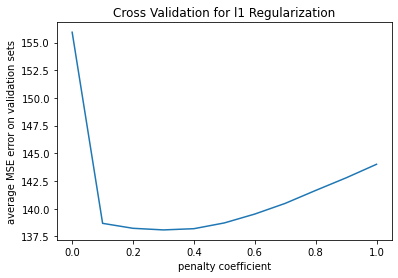

The best penalty coefficient is 0.30000000000000004
Time:  9.839469792000003
model trained using MSE loss
y-intercept  14.35352611541748
Coefficients  [[-1.2609164e-01  3.5676821e-03 -1.6072759e-03  2.3027251e-03
   3.5039841e-03  1.8082161e-01 -4.4275941e-03 -4.0375906e-01
   1.0603235e+00  3.1685927e-03  3.6629406e-01  3.8193245e+00
  -4.9412823e-01  4.2796165e-01  6.3814692e+00 -1.5063648e-01
   9.7296441e-01 -4.5821262e-03 -7.1285087e-01  5.6996379e+00
   3.0267367e+00  1.7539505e+00  6.3450880e+00 -5.0920277e+00
  -6.2815583e-01  1.9787408e+00 -1.0823955e-02  3.1075987e-01
   4.0775421e-03 -4.1141151e-03  1.9348992e-01  2.0220518e+00
   4.3514377e-01 -2.7483657e-01 -2.2504507e-01]]
Train MSE = 60.58629307704266
Train R^2 = 0.7533864327220546
Train SPO Loss = [2051.15523677]


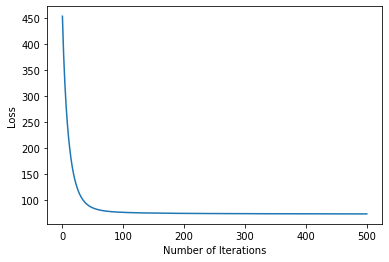

In [16]:
# l1 regularization (lasso) - penalty coefficient set to be 0.1

learningRate = 0.02
epochs = 501

best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1')
model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1)

### MSE loss model evaluation

In [17]:
# compile results for models trained on MSE loss
MSE_result = []

for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    MSE_result.append(pd.concat({name:score_df}))
    
MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])
MSE_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
mse_ols   train  58.000711  0.763911  2050.936431         10.358265   
          test   65.387871  0.596110   642.627655         11.274169   
mse_ridge train  60.260788  0.754711  1926.062177          9.727587   
          test   61.564548  0.619726   577.781952         10.136525   
mse_lasso train  60.586293  0.753386  2051.155237         10.359370   
          test   59.414814  0.633005   589.059763         10.334382   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Ord  
mse_ols   train            1054.468571                       5.325599  
          test              354.007763                       6.210663  
mse_ridge train             993.161482                       5.015967  
          test              319.673250                       5.608303  
mse_lasso train            1055.870765                       5.332681  
          test              324.237288                       5.688373

## SPO loss models

### SPO loss model training

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


model trained using SPO loss
y-intercept  8.555200576782227
Coefficients  [[ 0.21362153  0.31541657  0.45280913  0.1493825   0.11484413  0.0237015
   0.13666409  0.11141356 -0.04500176  0.33657935  1.6277934   2.0220926
   0.14706771  3.1140351   1.8583994  -0.39007837  2.3469746  -1.0935359
  -1.2651378   4.3601084   0.36675984  1.0958599   1.8154361  -2.4767041
  -0.28487217  0.89511603  0.26983193  0.43085447 -0.02749953 -0.05375894
   0.00503786  0.3036064  -0.01711228 -0.63755834 -1.2463019 ]]
Train MSE = 149.27387328290789
Train R^2 = 0.39238793921783865
Train SPO Loss = [1089.12545782]


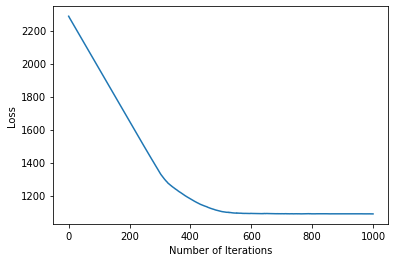

In [18]:
# ols

learningRate = 0.02
epochs = 1001

# model training
model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None')

model trained using SPO loss
y-intercept  8.441022872924805
Coefficients  [[ 0.0098631  -0.15575092  0.17555793  0.16726017 -0.11634542  0.01701425
   0.2584521  -0.02406929  0.14079629  0.03224469  1.1391791   1.2037431
   0.09656181  2.1399064   1.8959688  -0.55226725  2.0651433  -0.7543591
  -1.1548699   4.185421    0.9002806   1.0428462   1.845978   -1.9663827
  -0.51329684  0.78308916  0.29087868  0.29122564  0.1406525   0.21198127
   0.12507112  0.33225822  0.17443457 -0.5408812  -0.8501052 ]]
Train MSE = 154.42909254973418
Train R^2 = 0.3714038692422197
Train SPO Loss = [1107.79111892]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


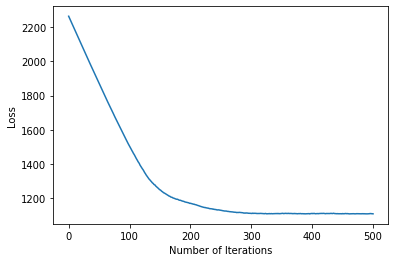

In [19]:
# ridge regression (l2 regrularization)

learningRate = 0.05
epochs = 501

# model training
best_l2_spo = 3.75
model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = best_l2_spo)

model trained using SPO loss
y-intercept  8.12996768951416
Coefficients  [[-1.0815148e-02  8.0874772e-04  5.6210551e-03  1.6098678e-01
   1.8660794e-05  6.1992288e-04  1.3856104e-01  5.3610546e-03
   4.3707907e-01 -8.0203830e-04  1.3010891e-01 -4.4992892e-03
  -7.1704162e-06  2.8265870e+00  2.1908360e+00 -3.4511438e-01
   1.4079386e+00 -3.8249374e-03 -4.7293395e-01  4.6471648e+00
   1.0834561e-02  4.4062440e-03  5.7132230e-03 -9.4859946e-01
  -3.5777277e-01  3.1270208e-03  1.8661360e-03 -2.4802689e-03
  -2.0397097e-02  2.4212783e-03  2.1661207e-01  3.8362462e-02
   1.6453579e-01 -2.4042691e-01 -2.8750211e-01]]
Train MSE = 191.7886770642999
Train R^2 = 0.2193334925739684
Train SPO Loss = [1185.98217516]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


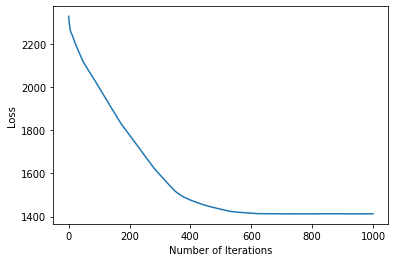

In [20]:
# l1 regularization (lasso)

learningRate = 0.02
epochs = 1001

best_l1_spo = 3.75
model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = 15)

### SPO MSE weighted loss model training

model trained using SPO_MSE loss
y-intercept  9.03581428527832
Coefficients  [[ 0.3722894   0.4657724   0.543233    0.27479717  0.11657268  0.06520213
   0.14747216  0.07344069 -0.07267347  0.22811672  1.5937495   2.845914
   0.1489165   3.0471318   2.4671335  -0.35741505  1.8559026  -1.1686254
  -1.2258242   4.211693    0.32857776  0.7480899   6.570251   -3.5044007
  -0.29201722  0.89396185  0.21620889  0.535983   -0.10746419 -0.06970628
  -0.07928591  0.16052672 -0.10396697 -0.8049954  -1.2319762 ]]
Train MSE = 119.09038610536875
Train R^2 = 0.5152483597468773
Train SPO Loss = [1090.59139367]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


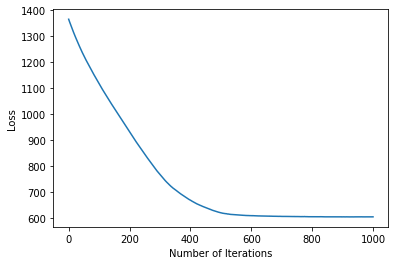

In [21]:
# ols

learningRate = 0.02
epochs = 1001

# model training
model_ols_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE','None')

model trained using SPO_MSE loss
y-intercept  8.004179954528809
Coefficients  [[-0.06036401  0.01242072  0.04359756  0.12066242 -0.0951957   0.10257629
   0.08439091 -0.01741393  0.31702548 -0.26076195  0.80861396  0.5985376
   0.051021    1.6276714   2.2191772  -0.62835747  1.7019991  -0.48768508
  -1.0479975   3.5923202   0.83540994  0.7065895   1.8888234  -1.6795738
  -0.6224057   0.6614691   0.19558907  0.24086669  0.11904789  0.04108093
   0.09405555  0.32080323  0.16631845 -0.4944641  -0.7180841 ]]
Train MSE = 162.57005532448184
Train R^2 = 0.338266475138829
Train SPO Loss = [1154.60099298]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


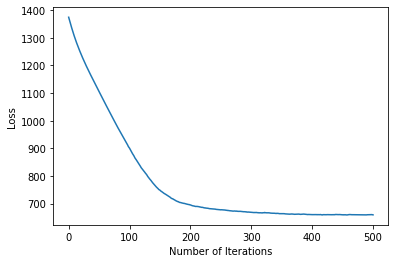

In [22]:
# ridge regression (l2 regrularization)

learningRate = 0.05
epochs = 501

# model training
best_l2_spo = 3.75
model_ridge_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE','l2', l2_penalty = best_l2_spo)

model trained using SPO_MSE loss
y-intercept  8.094619750976562
Coefficients  [[-1.28692074e-03 -7.67375203e-03  2.12945081e-02  3.69832329e-02
  -5.27702039e-04  1.48230996e-02  2.69714147e-02 -2.24037897e-02
   2.75914311e-01  1.62061525e-03  4.57565300e-03  2.07996508e-03
  -7.78310816e-04  2.49131966e+00  2.36128736e+00 -5.38045228e-01
   1.10463619e+00  2.01872038e-03 -5.53758621e-01  4.40955496e+00
   6.13227813e-03  1.64026325e-03 -9.47725726e-04 -1.04916930e+00
  -5.27578056e-01  1.34334376e-04  8.30555684e-04  6.97261933e-03
  -2.93439906e-03  1.98029447e-03  5.50753810e-02  2.14314461e-02
   1.41792931e-03 -1.34336531e-01 -1.23538606e-01]]
Train MSE = 193.35935669988777
Train R^2 = 0.2129401173019314
Train SPO Loss = [1215.13597156]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


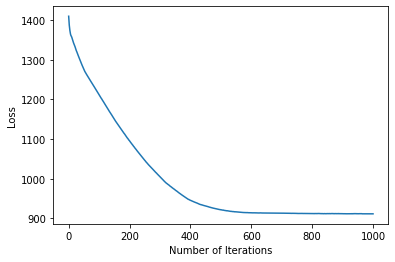

In [23]:
# l1 regularization (lasso)

learningRate = 0.02
epochs = 1001

best_l1_spo = 3.75
model_lasso_spo_mse = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO_MSE', 'l1', l1_penalty = 15)

### SPO loss model evaluation

In [24]:
# compile results for models trained on SPO loss
SPO_result = []

for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
spo_ols   train  149.273873  0.392388  1089.125458          5.500634   
          test    98.731346  0.390153   405.046085          7.106072   
spo_ridge train  154.429093  0.371404  1107.791119          5.594905   
          test    99.278224  0.386775   385.587132          6.764687   
spo_lasso train  191.788677  0.219333  1185.982175          5.989809   
          test    98.921453  0.388979   351.597560          6.168378   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Ord  
spo_ols   train             619.199666                       3.127271  
          test              251.888716                       4.419100  
spo_ridge train             631.110106                       3.187425  
          test              242.432678                       4.253205  
spo_lasso train             688.885426                       3.479219  
          test              225.259506                       3.951921

In [25]:
# SPO MSE weighted loss
SPO_result = []

for model, name in zip([model_ols_spo_mse, model_ridge_spo_mse, model_lasso_spo_mse],['spo_mse_ols','spo_mse_ridge','spo_mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
spo_mse_ols   train  119.090386  0.515248  1090.591394          5.508037   
              test    93.459813  0.422715   410.749490          7.206131   
spo_mse_ridge train  162.570055  0.338266  1154.600993          5.831318   
              test   106.635148  0.341333   360.084949          6.317280   
spo_mse_lasso train  193.359357  0.212940  1215.135972          6.137050   
              test   100.910318  0.376694   347.692733          6.099873   

                     SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Ord  
spo_mse_ols   train             604.840890                       3.054752  
              test              252.104652                       4.422889  
spo_mse_ridge train             658.585524                       3.326190  
              test              233.360049                       4.094036  
spo_mse_lasso train             704.247664                       3.556806  
              test              224.301525                       3.935114

In [26]:
MSE_scores

MSE       R^2     SPO_Loss  SPO_Loss_Per_Ord  \
mse_ols   train  58.000711  0.763911  2050.936431         10.358265   
          test   65.387871  0.596110   642.627655         11.274169   
mse_ridge train  60.260788  0.754711  1926.062177          9.727587   
          test   61.564548  0.619726   577.781952         10.136525   
mse_lasso train  60.586293  0.753386  2051.155237         10.359370   
          test   59.414814  0.633005   589.059763         10.334382   

                 SPO_MSE_Weighted_Loss  SPO_MSE_Weighted_Loss_Per_Ord  
mse_ols   train            1054.468571                       5.325599  
          test              354.007763                       6.210663  
mse_ridge train             993.161482                       5.015967  
          test              319.673250                       5.608303  
mse_lasso train            1055.870765                       5.332681  
          test              324.237288                       5.688373

# References

In [27]:
%%script false --no-raise-error
import time
# Batch Gradient Descent Using Numpy - For comparison purpose

"""
code is based on Yuhan Cheng's code, approved use
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    alpha = 0.0
    beta = np.zeros((xvalue_matrix.shape[1],))
    epsilon = 0.00001
    n = float(len(xvalue_matrix))
    loss = []
    for i in range(MaxIterations):
        # compute new coefficients
        y_pred = alpha + np.matmul(xvalue_matrix, beta)
        loss.append(mean_squared_error(y_pred,yvalues))
#         if i % 100 == 0:
#             print('Current Loss:', loss)
        d_alpha = np.mean(y_pred - yvalues)
        d_beta = np.mean((y_pred - yvalues) * xvalue_matrix.T, axis = 1)
        alpha_1 = alpha - (R * d_alpha)
        beta_1 = beta - (R * d_beta)
        
        if np.isnan(alpha_1):
            print('nan at iter', str(i))
            break
        
        # check to see whether stopping criteria has been met
        if (np.abs(alpha_1-alpha)<epsilon) and np.all(np.abs(beta_1-beta)<epsilon):
            alpha, beta = alpha_1, beta_1
            print('error < epsilon, criteria met')
            break
        alpha, beta = alpha_1, beta_1
            
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print('MSE:', str(loss[-1]))
    print('R2:', str(r2_score(y_true=yvalues, y_pred = y_pred)))
    
    plt.plot(range(len(loss)),loss)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    return alpha, beta

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
